In [5]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser
import copy
import datetime
import itertools
from operator import itemgetter
import numpy as np
from dateutil.tz import tzutc
import math
import pytz
from pytz import timezone
import pickle
import pylab
from scipy.stats import probplot,expon,kstest,norm
import matplotlib.pyplot as plt
import json
from datetime import timedelta
import pandas as pd
from scipy.stats.stats import pearsonr
import bisect
import scipy.stats as ss
import bisect
from mpl_toolkits.mplot3d import Axes3D

# Load Data

In [2]:
def parse_file_json(file_name):
    with open(file_name, "r") as f:
        data = [json.loads(line) for line in f]
    starting_time = parser.parse(data[0][0])
    starting_bids = data[0][1]
    starting_asks = data[0][2]
    
    raw_updates = data[1:]
    
    Bids = {}
    Asks = {}    
    
    updates = []
    
    for price, amount in starting_bids:
        Bids[int(round((float(price)*100)))] = float(amount)
    for price, amount in starting_asks:
        Asks[int(round((float(price)*100)))] = float(amount)
        
    for u in raw_updates:
        price = int(round((float(u["price"])*100)))  
        side = u["side"]
        amount = float(u["amount"])
        time = parser.parse(u["time"])
        
        if side == "buy":
            change = amount - Bids.get(price,0)
        else:
            change = amount - Asks.get(price,0)
        
        updates.append({\
            "Bids": copy.copy(Bids), \
            "Asks": copy.copy(Asks), \
            "time": time, \
            "side": side, \
            "price": price, \
            "change": change            
        })
        
        if side == "buy":
            if u["amount"] == "0":
                del Bids[price]
            else:
                Bids[price] = float(amount)
        else:
            if u["amount"] == "0":
                del Asks[price]
            else:
                Asks[price] = float(amount)   

    return(starting_time, updates)

In [3]:
def shortened_updates(file_name,K):
    starting_time, updates = parse_file_json(file_name)
    
    res = []
    
    # Caluclate first reference price
    starting_bids = updates[0]['Bids']
    starting_asks = updates[0]['Asks']
    sorted_bids = list(reversed(sorted(starting_bids.items())))
    sorted_asks = list(sorted(starting_asks.items()))        
    best_bid = sorted_bids[0][0]
    best_ask = sorted_asks[0][0]
    if ((best_bid + best_ask) % 2) != 0:
        old_reference_price = round((best_bid+best_ask)/2, 1)
    else:
        old_reference_price = round((best_bid+best_ask+1)/2, 1)
            
    for u in updates:      
        # Find reference price
        sorted_bids = list(reversed(sorted(u['Bids'].items())))
        sorted_asks = list(sorted(u['Asks'].items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            reference_price = round((best_bid+best_ask)/2, 1)
        else:
            middle = (best_bid+best_ask)/2
            if old_reference_price > middle:
                reference_price = round((best_bid+best_ask)/2 + 0.5,1)
            else:
                old_reference_price = round((best_bid+best_ask)/2 - 0.5,1)
                
        shortened_book = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
        first_bid = int(round(reference_price - 0.5))
        first_ask = int(round(reference_price + 0.5))        
        for k in range(-K,0):
            shortened_book[k] = u['Bids'].get(first_bid + k + 1,0)
        for k in range(1,K+1):
            shortened_book[k] = u['Asks'].get(first_ask + k - 1,0)
            
        # Find k from the price. Keep track of event if
        # abs(k) <= K
        price = u["price"]
        k = price - reference_price
        if k < 0:
            k = int(round(k - 0.5))
        else:
            k = int(round(k + 0.5))
        if abs(k) <= K:                 
            res.append({
                'reference_price': reference_price,
                'LOB': copy.copy(shortened_book),
                'k': k,
                'change': u['change'],
                'time': u['time']
            })
        
        old_reference_price = reference_price

    return starting_time, res

# Combine Updates that Occur At Same Time

# Combine Orders that Occur in Quick Succession
### (Orders that occur within 0.01 seconds of each other)

In [4]:
def processed_updates(file_name,K):
    starting_time,updates = shortened_updates(file_name,10)
    grouped_by_time = OrderedDict([(k, list(v)) for k, v in itertools.groupby(updates, key=lambda x:x['time'])])
    # Contains dictionary of time, reference price, order book, list of changes
    cleaned_updates = []
    for t, us in grouped_by_time.items():
        if len(us) == 1:
            u = us[0]
            cleaned_updates.append(copy.copy(u))
        else:
            new_update = {'time': t}
            us = sorted(us, key=lambda u:-abs(u['k']))
            grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(us, key=lambda u:u['k']))
            reference_k = list(grouped_by_k.keys())[0]
            new_update['reference_price'] = grouped_by_k[reference_k][0]['reference_price']
            new_update['LOB'] = copy.copy(grouped_by_k[reference_k][0]['LOB'])
            events = []
            for k in grouped_by_k:
                combined_change = 0
                for u in grouped_by_k[k]:
                    combined_change = combined_change + u['change']
                events.append((k,combined_change))
            for k,change in events:
                new_update = copy.deepcopy(new_update)
                new_update['k'] = k
                new_update['change'] = change
                cleaned_updates.append(new_update)
    
    combined_updates = []
    i = 0
    while i < len(cleaned_updates):
        reference_price = cleaned_updates[i]['reference_price']
        j = i
        updates_at_reference = []
        while (j < len(cleaned_updates)) and (cleaned_updates[j]['reference_price'] == reference_price):
            updates_at_reference.append(cleaned_updates[j])
            j += 1
        updates_at_reference = sorted(updates_at_reference,key=lambda u:u['k'])
        grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(updates_at_reference, key=lambda u:u['k']))
        for k,us in grouped_by_k.items():
            us = copy.deepcopy(sorted(us,key=lambda u:u['time']))
            keep_index = [True for u in us]
            for m in reversed(range(1,len(us))):
                quick_same_order = (us[m]['time'] - us[m-1]['time']).total_seconds() < 0.01
                same_sign = (us[m]['change'] * us[m-1]['change']) > 0
                if quick_same_order and same_sign:
                    us[m-1]['change'] += us[m]['change']
                    keep_index[m] = False
            for (u,keep) in zip(us, keep_index):
                if keep:
                    combined_updates.append(u)
        i = j + 1

    combined_updates = sorted(combined_updates,key=lambda u:u['time'])
    
    ending_time = combined_updates[-1]['time']
    
    return starting_time, ending_time, combined_updates

starting_time, ending_time, combined_updates = processed_updates('12_28_18.json',10)
len(combined_updates)

305806

In [5]:
starting_times, ending_times, time_period_updates = zip(*[processed_updates(f,10) for f in ['12_28_18.json','12_29_18.json','12_30_18.json']])

In [64]:
with open('processed_data.pkl', 'wb') as f:
    pickle.dump([starting_times, ending_times, time_period_updates], f)

# START HERE

In [10]:
with open('processed_data.pkl', 'rb') as f:
    starting_times, ending_times, all_updates = pickle.load(f)

In [11]:
all_update_times = []
for updates in all_updates:
    all_update_times.append([u['time'] for u in updates])

# Sample intervals

In [13]:
def updates_during_period(updates, update_times, start, end):
    left_index = bisect.bisect_left(update_times, start)
    right_index = bisect.bisect_right(update_times, end)
    return updates[left_index: right_index + 1]
    
def updates_during_random_period(updates, update_times, starting_time, ending_time, size):
    total_length = (ending_time - starting_time).total_seconds()
    interval_start = starting_time + timedelta(seconds=np.random.uniform()*(total_length - size))
    return updates_during_period(updates, update_times, interval_start, interval_start + timedelta(seconds=size))

def updates_during_random_period_multiple_dates(size):
    probabilities = [(e-s).total_seconds() - size for (s,e) in zip(starting_times, ending_times)]
    probabilities = [p/sum(probabilities) for p in probabilities]
    I = np.random.choice(len(all_updates), p=probabilities)
    return updates_during_random_period(all_updates[I], all_update_times[I], starting_times[I], ending_times[I], size)

In [14]:
K = 10
positive_updates = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])
negative_updates = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])

for _ in range(160000):
    updates = updates_during_random_period_multiple_dates(60)
    num_positive = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    num_negative = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    
    for u in updates:
        if u['change'] > 0:
            num_positive[u['k']] += 1
        else:
            num_negative[u['k']] += 1
            
    for k in range(-K,K+1):
        if k != 0:
            positive_updates[k].append(num_positive[k])
            negative_updates[k].append(num_negative[k])

# Full Correlation Matrix

In [15]:
observations = []
for k in positive_updates:
    observations.append(positive_updates[k])
for k in negative_updates:
    observations.append(negative_updates[k])
sigma = np.corrcoef(observations)
sigma

array([[1.        , 0.34893391, 0.24678655, ..., 0.09227261, 0.09563561,
        0.09574652],
       [0.34893391, 1.        , 0.4390286 , ..., 0.09443737, 0.17353733,
        0.09320871],
       [0.24678655, 0.4390286 , 1.        , ..., 0.11521098, 0.23111952,
        0.07653251],
       ...,
       [0.09227261, 0.09443737, 0.11521098, ..., 1.        , 0.24567751,
        0.14004848],
       [0.09563561, 0.17353733, 0.23111952, ..., 0.24567751, 1.        ,
        0.24882431],
       [0.09574652, 0.09320871, 0.07653251, ..., 0.14004848, 0.24882431,
        1.        ]])

In [24]:
df = pd.DataFrame(positive_updates)
pos_pos_correlations = df.corr()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            pos_pos_correlations[i][j] = round(np.corrcoef(positive_updates[i], positive_updates[j])[0][1],3)
            
with pd.ExcelWriter('pos_pos_correlations.xlsx') as writer:
    pos_pos_correlations.to_excel(writer)
            
pos_pos_correlations

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1.000,0.349,0.247,0.231,0.203,0.166,0.130,0.138,0.050,0.072,0.090,0.070,0.045,0.047,-0.002,0.019,0.073,0.079,0.081,0.094
-9,0.349,1.000,0.439,0.301,0.232,0.167,0.123,0.138,0.113,0.133,0.149,0.136,0.096,0.050,0.016,0.022,0.062,0.091,0.157,0.115
-8,0.247,0.439,1.000,0.600,0.435,0.265,0.198,0.221,0.098,0.141,0.162,0.159,0.086,0.036,0.011,0.029,0.064,0.090,0.200,0.095
-7,0.231,0.301,0.600,1.000,0.629,0.318,0.159,0.189,0.044,0.143,0.143,0.160,0.121,0.019,0.021,-0.019,0.029,0.107,0.125,0.061
-6,0.203,0.232,0.435,0.629,1.000,0.639,0.298,0.230,0.045,0.134,0.195,0.205,0.172,0.093,-0.003,-0.012,0.039,0.108,0.131,0.070
-5,0.166,0.167,0.265,0.318,0.639,1.000,0.529,0.344,0.142,0.200,0.255,0.222,0.212,0.156,0.089,0.060,0.071,0.089,0.129,0.070
-4,0.130,0.123,0.198,0.159,0.298,0.529,1.000,0.539,0.235,0.229,0.241,0.232,0.224,0.204,0.150,0.143,0.143,0.110,0.149,0.100
-3,0.138,0.138,0.221,0.189,0.230,0.344,0.539,1.000,0.395,0.248,0.239,0.256,0.237,0.206,0.128,0.134,0.184,0.143,0.184,0.110
-2,0.050,0.113,0.098,0.044,0.045,0.142,0.235,0.395,1.000,0.333,0.221,0.205,0.164,0.133,0.127,0.147,0.180,0.125,0.171,0.108
-1,0.072,0.133,0.141,0.143,0.134,0.200,0.229,0.248,0.333,1.000,0.276,0.213,0.193,0.233,0.219,0.184,0.195,0.149,0.172,0.111


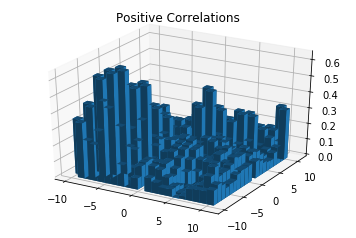

In [29]:
xs = []
ys = []
dx = 1
dy = 1
dz = []
for k1 in range(-K,K+1):
    if k1 != 0:
        for k2 in range(-K,K+1):
            if k2 != 0:
                if k1 != k2:
                    xs.append(k1)
                    ys.append(k2)
                    dz.append(pos_pos_correlations[k1][k2])
                
zs = np.zeros(len(xs))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.bar3d(xs, ys, zs, dx, dy, dz, shade=True)
plt.title("Positive Correlations")
plt.savefig('pos_pos_correlations')
plt.show()

In [33]:
pos_neg_correlations = pos_pos_correlations.copy()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            pos_neg_correlations[i][j] = round(np.corrcoef(positive_updates[i], negative_updates[j])[0][1],3)

with pd.ExcelWriter('pos_neg_correlations.xlsx') as writer:
    pos_neg_correlations.to_excel(writer)
            
pos_neg_correlations

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,0.651,0.346,0.273,0.225,0.210,0.174,0.148,0.174,0.115,0.121,0.125,0.121,0.094,0.083,0.028,0.055,0.090,0.109,0.117,0.095
-9,0.312,0.843,0.428,0.274,0.215,0.165,0.138,0.139,0.120,0.151,0.124,0.148,0.120,0.081,0.036,0.039,0.073,0.098,0.175,0.112
-8,0.218,0.449,0.904,0.592,0.416,0.247,0.175,0.181,0.090,0.161,0.139,0.164,0.104,0.044,0.014,0.033,0.066,0.091,0.175,0.081
-7,0.222,0.284,0.601,0.961,0.622,0.315,0.154,0.178,0.053,0.162,0.131,0.159,0.125,0.027,0.023,-0.019,0.030,0.118,0.137,0.066
-6,0.196,0.225,0.431,0.621,0.965,0.641,0.291,0.211,0.040,0.143,0.177,0.206,0.180,0.093,0.002,-0.009,0.038,0.111,0.134,0.073
-5,0.166,0.174,0.271,0.321,0.642,0.972,0.542,0.352,0.156,0.223,0.250,0.237,0.230,0.173,0.108,0.081,0.092,0.105,0.147,0.083
-4,0.134,0.138,0.201,0.158,0.291,0.534,0.969,0.538,0.239,0.240,0.233,0.239,0.236,0.213,0.158,0.159,0.154,0.112,0.152,0.104
-3,0.144,0.152,0.231,0.195,0.240,0.350,0.555,0.967,0.422,0.257,0.247,0.270,0.251,0.217,0.130,0.138,0.195,0.156,0.195,0.117
-2,0.085,0.147,0.148,0.100,0.103,0.201,0.300,0.491,0.949,0.387,0.265,0.232,0.195,0.165,0.154,0.174,0.213,0.145,0.194,0.117
-1,0.090,0.128,0.166,0.158,0.175,0.220,0.235,0.258,0.311,0.904,0.297,0.163,0.135,0.195,0.184,0.138,0.134,0.102,0.131,0.099


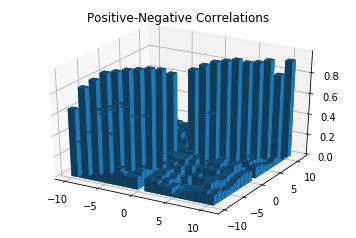

In [34]:
xs = []
ys = []
dx = 1
dy = 1
dz = []
for k1 in range(-K,K+1):
    if k1 != 0:
        for k2 in range(-K,K+1):
            if k2 != 0:
                xs.append(k1)
                ys.append(k2)
                dz.append(pos_neg_correlations[k1][k2])
                
zs = np.zeros(len(xs))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.bar3d(xs, ys, zs, dx, dy, dz, shade=True)
plt.title("Positive-Negative Correlations")
plt.savefig('pos_neg_correlations')
plt.show()

In [35]:
neg_neg_correlations = pos_pos_correlations.copy()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            neg_neg_correlations[i][j] = round(np.corrcoef(negative_updates[i], negative_updates[j])[0][1],3)

with pd.ExcelWriter('neg_neg_correlations.xlsx') as writer:
    neg_neg_correlations.to_excel(writer)
            
neg_neg_correlations

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1.000,0.349,0.247,0.231,0.203,0.166,0.130,0.138,0.050,0.072,0.090,0.070,0.045,0.047,-0.002,0.019,0.073,0.079,0.081,0.094
-9,0.349,1.000,0.439,0.301,0.232,0.167,0.123,0.138,0.113,0.133,0.149,0.136,0.096,0.050,0.016,0.022,0.062,0.091,0.157,0.115
-8,0.247,0.439,1.000,0.600,0.435,0.265,0.198,0.221,0.098,0.141,0.162,0.159,0.086,0.036,0.011,0.029,0.064,0.090,0.200,0.095
-7,0.231,0.301,0.600,1.000,0.629,0.318,0.159,0.189,0.044,0.143,0.143,0.160,0.121,0.019,0.021,-0.019,0.029,0.107,0.125,0.061
-6,0.203,0.232,0.435,0.629,1.000,0.639,0.298,0.230,0.045,0.134,0.195,0.205,0.172,0.093,-0.003,-0.012,0.039,0.108,0.131,0.070
-5,0.166,0.167,0.265,0.318,0.639,1.000,0.529,0.344,0.142,0.200,0.255,0.222,0.212,0.156,0.089,0.060,0.071,0.089,0.129,0.070
-4,0.130,0.123,0.198,0.159,0.298,0.529,1.000,0.539,0.235,0.229,0.241,0.232,0.224,0.204,0.150,0.143,0.143,0.110,0.149,0.100
-3,0.138,0.138,0.221,0.189,0.230,0.344,0.539,1.000,0.395,0.248,0.239,0.256,0.237,0.206,0.128,0.134,0.184,0.143,0.184,0.110
-2,0.050,0.113,0.098,0.044,0.045,0.142,0.235,0.395,1.000,0.333,0.221,0.205,0.164,0.133,0.127,0.147,0.180,0.125,0.171,0.108
-1,0.072,0.133,0.141,0.143,0.134,0.200,0.229,0.248,0.333,1.000,0.276,0.213,0.193,0.233,0.219,0.184,0.195,0.149,0.172,0.111


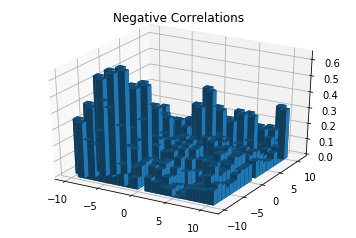

In [38]:
xs = []
ys = []
dx = 1
dy = 1
dz = []
for k1 in range(-K,K+1):
    if k1 != 0:
        for k2 in range(-K,K+1):
            if k2 != 0:
                if k1 != k2:
                    xs.append(k1)
                    ys.append(k2)
                    dz.append(neg_neg_correlations[k1][k2])
                
zs = np.zeros(len(xs))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.bar3d(xs, ys, zs, dx, dy, dz, shade=True)
plt.title("Negative Correlations")
plt.savefig('neg_neg_correlations')
plt.show()

# Find Average Event Sizes and Average Rate

In [41]:
K = 10
def AES_and_Rate(updates, starting_times):
    event_sizes_pos = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])
    event_sizes_neg = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])
    
    for updates in all_updates:
        for u in updates:
            if u['change'] > 0:
                event_sizes_pos[u['k']].append(u['change'])
            else:
                event_sizes_neg[u['k']].append(-u['change'])
                
    total_time = np.sum([(e-s).total_seconds() for s,e in zip(starting_times,ending_times)])
                
    AESs = OrderedDict([((k,"pos"),0) for k in range(-K,K+1) if k != 0] + \
                       [((k,"neg"),0) for k in range(-K,K+1) if k != 0])
    numbers_of_events = OrderedDict([((k,"pos"),0) for k in range(-K,K+1) if k != 0] + \
                                   [((k,"neg"),0) for k in range(-K,K+1) if k != 0])
    average_rates = OrderedDict([((k,"pos"),0) for k in range(-K,K+1) if k != 0] + \
                                [((k,"neg"),0) for k in range(-K,K+1) if k != 0])
    
    for (k,sizes) in event_sizes_pos.items():
        AESs[(k,"pos")] = np.mean(sizes)
        numbers_of_events[(k,"pos")] = len(sizes)
        
    for (k,sizes) in event_sizes_neg.items():
        AESs[(k,"neg")] = np.mean(sizes)
        numbers_of_events[(k,"neg")] = len(sizes)
        
    for k in numbers_of_events:
        average_rates[k] = numbers_of_events[k] / total_time
        
    return AESs, numbers_of_events, average_rates
            

AESs, numbers_of_events, average_rates = AES_and_Rate(all_updates, starting_times)

data = []

for k in range(-K,K+1):
    if k != 0:
        print("k = {}".format(k))
        print("AES Positive: {}".format(AESs[(k,"pos")]))
        print("n = {}".format(numbers_of_events[(k,"pos")]))
        print("Average Rate: {}".format(average_rates[(k,"pos")]))
        print("Multiplied: {}".format(AESs[(k,"pos")]*average_rates[(k,"pos")]))
        print("AES Negative: {}".format(AESs[(k,"neg")]))
        print("n = {}".format(numbers_of_events[(k,"neg")]))
        print("Average Rate: {}".format(average_rates[(k,"neg")]))
        print("Multiplied: {}".format(AESs[(k,"neg")]*average_rates[(k,"neg")]))
        print()
        
        data.append([k, numbers_of_events[(k,"pos")], round(AESs[(k,"pos")],2), round(average_rates[(k,"pos")],4),\
                    round(AESs[(k,"pos")]*average_rates[(k,"pos")],2), numbers_of_events[(k,"neg")], \
                     round(AESs[(k,"neg")],2), round(average_rates[(k,"neg")],4), \
                     round(AESs[(k,"neg")]*average_rates[(k,"neg")],2)])
        
with pd.ExcelWriter('aes_rate.xlsx') as writer:
    pd.DataFrame(data).to_excel(writer)

k = -10
AES Positive: 601.4124541063055
n = 406
Average Rate: 0.0015663206844764182
Multiplied: 0.9420047667684309
AES Negative: 597.758153757424
n = 493
Average Rate: 0.0019019608311499365
Multiplied: 1.1369125949471217

k = -9
AES Positive: 479.6863613652646
n = 699
Average Rate: 0.0026966949715493014
Multiplied: 1.29356779861449
AES Negative: 446.5999332116102
n = 739
Average Rate: 0.002851012280364712
Multiplied: 1.273261893996361

k = -8
AES Positive: 584.5728342409202
n = 1554
Average Rate: 0.005995227447478704
Multiplied: 3.5046471008915834
AES Negative: 552.6849764006743
n = 1602
Average Rate: 0.006180408218057197
Multiplied: 3.4158187701434755

k = -7
AES Positive: 530.3406793258122
n = 5633
Average Rate: 0.021731735013930206
Multiplied: 11.525223110216285
AES Negative: 534.065776466186
n = 5417
Average Rate: 0.020898421546326987
Multiplied: 11.161131730056793

k = -6
AES Positive: 520.9486674717087
n = 13115
Average Rate: 0.050596787627852774
Multiplied: 26.358329093078943
AE

In [45]:
AESs_vector = []
average_rates_vector = []
for k in range(-K,K+1):
    if k != 0:
        AESs_vector.append(AESs[(k,"pos")])
        average_rates_vector.append(average_rates[(k,"pos")])
for k in range(-K,K+1):
    if k != 0:
        AESs_vector.append(AESs[(k,"neg")])
        average_rates_vector.append(average_rates[(k,"neg")])

# Find Average Size at Each Position

In [33]:
total_time = sum([(e-s).total_seconds() for s,e in zip(starting_times, ending_times)])
weighted_sums = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
average_price = 0
for i in range(len(all_updates)):
    prev_time = starting_times[i]
    for u in all_updates[i]:
        t = u['time']
        for k in range(-K,K+1):
            if k != 0:
                weighted_sums[k] += u['LOB'][k] * (t - prev_time).total_seconds()
        average_price += u['reference_price'] * (t - prev_time).total_seconds()
        prev_time = t
        
    last_LOB = copy.deepcopy(all_updates[i][-1]['LOB'])
    last_LOB[all_updates[i][-1]['k']] += all_updates[i][-1]['change']
    for k in range(1,K+1):
        if last_LOB[k] > 0:
            first_ask_price = round(all_updates[i][-1]['reference_price'] - 0.5 + k)
            break
    for k in reversed(range(-K,0)):
        if last_LOB[k] > 0:
            first_bid_price = round(all_updates[i][-1]['reference_price'] + 0.5 + k)
            break
    if (first_ask_price - first_bid_price) % 2 != 0:
        last_ref_price = round(float(first_ask_price + first_bid_price) / 2,1)
    else:
        middle_price = round((first_ask_price + first_bid_price)/2)
        if middle_price < ref_price:
            last_ref_price = round(middle_price + 0.5, 1)
        else:
            last_ref_price = round(middle_price - 0.5, 1)
            
    for k in range(-K,K+1):
        if k != 0:
            weighted_sums[k] += last_LOB[k]*(ending_times[i] - all_updates[i][-1]['time']).total_seconds()
    average_price += last_ref_price * (ending_times[i] - all_updates[i][-1]['time']).total_seconds()
            
average_sizes = copy.deepcopy(weighted_sums)
for k in range(-K,K+1):
    if k != 0:
        average_sizes[k] = weighted_sums[k] / total_time
        
average_price = average_price / total_time
    
print("Average price: {}".format(average_price))
print("Average Sizes:")
average_sizes

Average price: 516.9074565838985
Average Sizes:


OrderedDict([(-10, 287.1343261066107),
             (-9, 250.14440598382774),
             (-8, 292.8595557315305),
             (-7, 609.8154879314532),
             (-6, 1338.8977034506945),
             (-5, 2578.2647828454283),
             (-4, 2735.4364300829075),
             (-3, 2328.270135971142),
             (-2, 1425.6754816026087),
             (-1, 587.9266763538596),
             (1, 495.78529919956264),
             (2, 983.2351859382003),
             (3, 1475.5901257103164),
             (4, 2170.5963486266273),
             (5, 2456.864847931035),
             (6, 1807.15589047753),
             (7, 817.156989876897),
             (8, 420.6087178769215),
             (9, 404.1115441720219),
             (10, 390.98856591945906)])

# Generated Correlated Arrivals

In [46]:
def inverse_PDF_Poisson(average, u):
    x = 0
    p = np.exp(-average)
    s = p
    while u > s:
        x += 1
        p = p * average / x
        s = s + p
    return x  

def arrivals_during_time_period(AESs, average_rates, correlations, start_time, T):
    correlated_normals = np.random.multivariate_normal(mean=[0 for _ in AESs], cov=correlations)
    us = [norm.cdf(y) for y in correlated_normals]
    num_arrivals = [inverse_PDF_Poisson(rate*T,u) for (rate,u) in zip(average_rates,us)]
    labels = [(k,"pos") for k in range(-K,K+1) if k != 0] + [(k,"neg") for k in range(-K,K+1) if k != 0]
    events = []
    for i,n in enumerate(num_arrivals):
        position, direction = labels[i]
        for _ in range(n):
            arrival_time = start_time + np.random.uniform()*T
            arrival_size = min(np.random.exponential(AESs[i]),5000)
            if direction == "neg":
                arrival_size *= -1
            events.append((arrival_time, arrival_size, position, False))
    return events        

In [23]:
events = arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, 0, 60)
events

[(32.036933220719, 510.3330242584175, -9, False),
 (39.722359946546504, 581.0318350364752, -7, False),
 (45.58315584785732, 52.158459833900764, -6, False),
 (34.16087864095958, 288.6926345186815, -6, False),
 (27.5128806224066, 718.3653932214833, -6, False),
 (10.467775550860232, 19.94057189195321, -6, False),
 (12.423277258854666, 107.80806991793324, -6, False),
 (54.4241011833952, 544.3021573392887, -5, False),
 (33.642533311509766, 508.3062772028102, -5, False),
 (55.53449971731744, 1533.163042428344, -5, False),
 (12.901519029557218, 545.7662874496507, -5, False),
 (18.503338247691158, 204.17130926822708, -5, False),
 (10.729358711125094, 1054.8374899573453, -5, False),
 (24.06419725725548, 856.2165209104211, -5, False),
 (38.00633363472805, 65.751403863569, -5, False),
 (23.367680915807917, 161.09887096581713, -5, False),
 (18.34791823169104, 363.9106512421335, -4, False),
 (39.739177843981615, 7.646295895565479, -4, False),
 (14.484054376489562, 453.8667737947574, -4, False),
 (3

# Plot Events

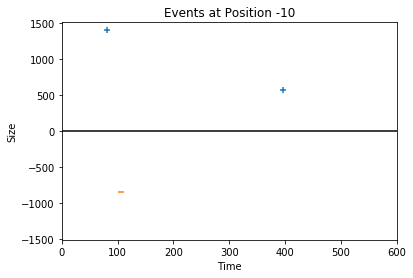

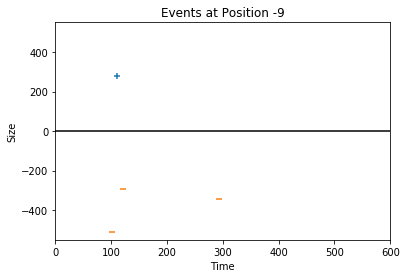

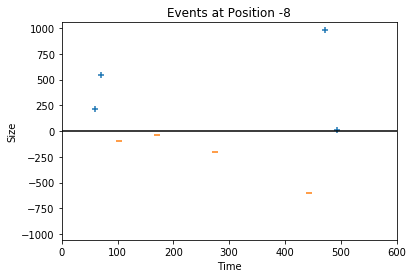

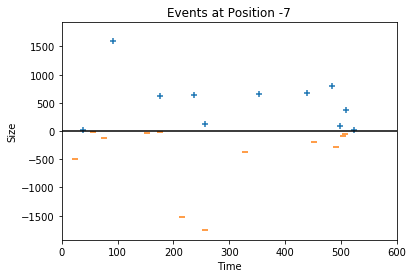

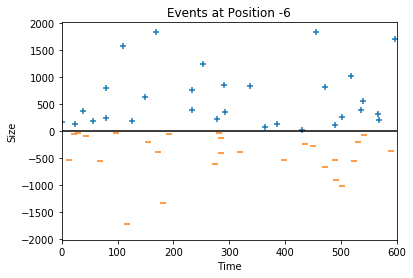

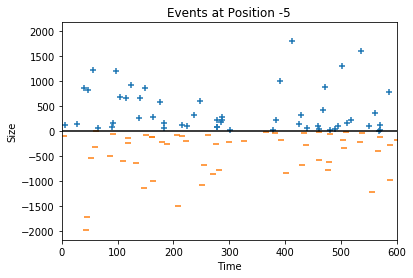

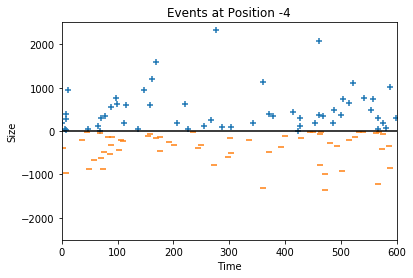

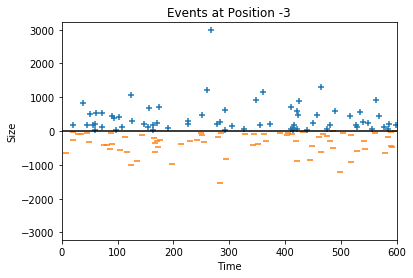

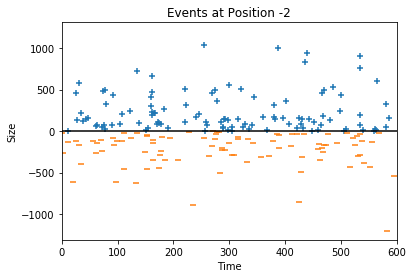

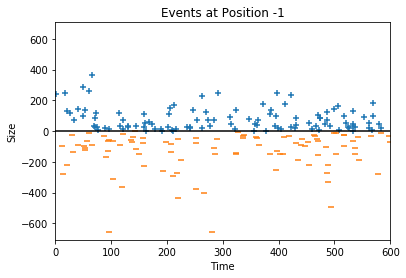

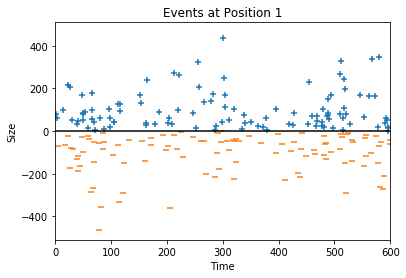

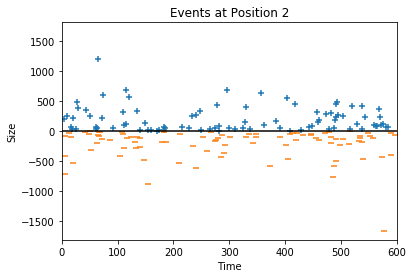

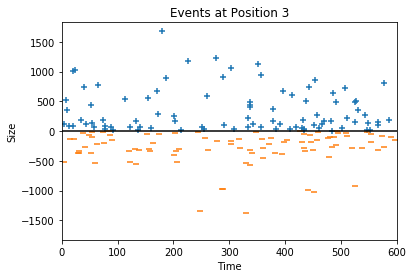

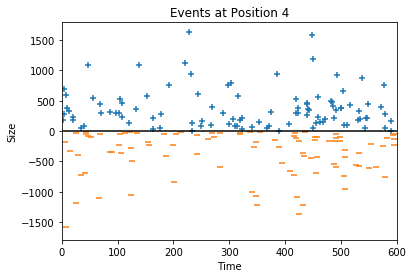

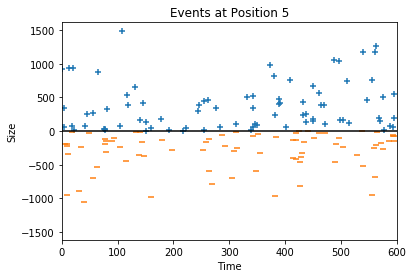

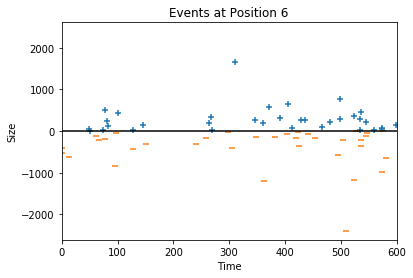

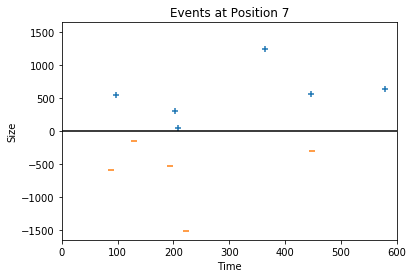

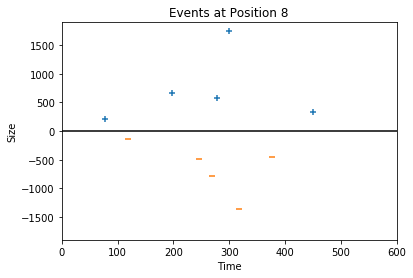

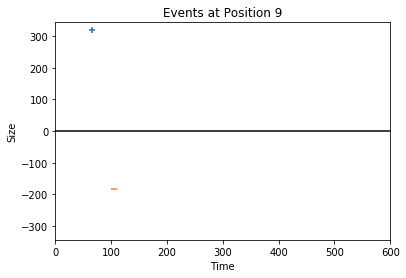

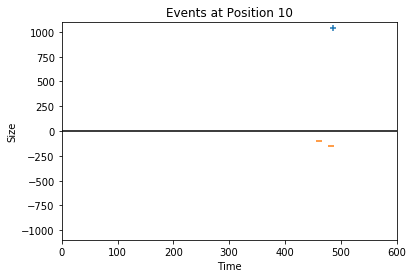

In [53]:
events = [arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, i*60, 60) for i in range(10)]
events = [e for es in events for e in es]

for k in range(-K,K+1):
    if k != 0:
        events_at_k = [(e[0],e[1]) for e in events if e[2] == k]
        positive_events = [e for e in events_at_k if e[1] > 0]
        if len(positive_events) > 0:
            positive_times, positive_sizes = zip(*positive_events)
        else:
            positive_times, positive_sizes = [],[]
        negative_events = [e for e in events_at_k if e[1] < 0]
        if len(negative_events) > 0:
            negative_times, negative_sizes = zip(*negative_events)
        else:
            negative_times, negative_sizes = [],[]
        plt.scatter(positive_times, positive_sizes, marker="+")
        plt.scatter(negative_times, negative_sizes, marker="_")
        plt.axhline(0,color='k')
        plt.xlim([0, 600])
        plt.xlabel("Time")
        plt.ylabel("Size")
        lower, upper = plt.gca().get_ylim()
        lim = max(abs(lower),abs(upper))
        plt.ylim([-lim,lim])
        plt.title("Events at Position {}".format(k))
        plt.savefig("Events/events{}".format(k))
        plt.show()
        
plt.close()

# Simulated Correlation

In [26]:
def num_arrivals_during_time_period(AESs, average_rates, correlations, start_time, T):
    correlated_normals = np.random.multivariate_normal(mean=[0 for _ in AESs], cov=correlations)
    us = [norm.cdf(y) for y in correlated_normals]
    num_arrivals = [inverse_PDF_Poisson(rate*T,u) for (rate,u) in zip(average_rates,us)]
    return num_arrivals

In [27]:
n = 10000
trials = [num_arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, 0, 60) for _ in range(n)]

In [28]:
simulated_correlations = np.corrcoef(trials,rowvar=False)

In [29]:
indices = {}
i = 0
for k in range(-K,K+1):
    if k != 0:
        indices[(k,"pos")] = i
        i += 1
for k in range(-K,K+1):
    if k != 0:
        indices[(k,"neg")] = i
        i += 1
        
pos_pos_correlations_simulated = pos_pos_correlations.copy()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            pos_pos_correlations_simulated[i][j] = simulated_correlations[indices[(i,"pos")]][indices[(j,"pos")]]
pos_pos_correlations_simulated_styled = \
    pos_pos_correlations_simulated.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
pos_pos_correlations_simulated_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1.000,0.171,0.136,0.147,0.120,0.084,0.085,0.102,0.030,0.039,0.047,0.031,0.015,0.041,-0.009,-0.003,0.042,0.010,0.037,0.022
-9,0.171,1.000,0.303,0.212,0.156,0.124,0.098,0.112,0.085,0.097,0.086,0.076,0.057,0.036,0.014,0.031,0.066,0.037,0.063,0.051
-8,0.136,0.303,1.000,0.505,0.348,0.206,0.179,0.200,0.072,0.130,0.128,0.116,0.078,0.042,-0.003,0.011,0.051,0.029,0.113,0.022
-7,0.147,0.212,0.505,1.000,0.587,0.287,0.165,0.194,0.042,0.132,0.144,0.157,0.114,0.036,0.031,-0.026,0.021,0.076,0.064,0.020
-6,0.120,0.156,0.348,0.587,1.000,0.610,0.303,0.226,0.039,0.131,0.208,0.214,0.170,0.110,0.019,-0.018,0.049,0.076,0.074,0.033
-5,0.084,0.124,0.206,0.287,0.610,1.000,0.519,0.322,0.128,0.188,0.261,0.220,0.207,0.154,0.098,0.054,0.060,0.053,0.075,0.022
-4,0.085,0.098,0.179,0.165,0.303,0.519,1.000,0.530,0.223,0.225,0.242,0.223,0.216,0.194,0.146,0.120,0.124,0.065,0.083,0.053
-3,0.102,0.112,0.200,0.194,0.226,0.322,0.530,1.000,0.388,0.233,0.253,0.251,0.228,0.195,0.126,0.119,0.176,0.094,0.120,0.060
-2,0.030,0.085,0.072,0.042,0.039,0.128,0.223,0.388,1.000,0.325,0.216,0.203,0.162,0.131,0.127,0.148,0.161,0.085,0.096,0.075
-1,0.039,0.097,0.130,0.132,0.131,0.188,0.225,0.233,0.325,1.000,0.271,0.198,0.190,0.238,0.230,0.180,0.166,0.104,0.102,0.037


In [30]:
pos_neg_correlations_simulated = pos_pos_correlations.copy()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            pos_neg_correlations_simulated[i][j] = simulated_correlations[indices[(i,"pos")]][indices[(j,"neg")]]
pos_neg_correlations_simulated_styled = \
    pos_neg_correlations_simulated.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
pos_neg_correlations_simulated_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,0.409,0.157,0.123,0.128,0.122,0.100,0.088,0.116,0.072,0.078,0.071,0.053,0.048,0.061,0.014,0.036,0.074,0.044,0.032,0.048
-9,0.155,0.630,0.276,0.182,0.137,0.127,0.113,0.107,0.084,0.118,0.080,0.091,0.089,0.066,0.033,0.035,0.074,0.046,0.075,0.036
-8,0.114,0.303,0.776,0.490,0.332,0.196,0.158,0.166,0.067,0.150,0.113,0.133,0.089,0.048,0.006,0.023,0.054,0.030,0.102,0.029
-7,0.138,0.202,0.501,0.903,0.584,0.282,0.151,0.179,0.049,0.146,0.131,0.154,0.120,0.050,0.038,-0.018,0.035,0.088,0.073,0.028
-6,0.114,0.157,0.345,0.574,0.935,0.612,0.296,0.209,0.038,0.135,0.184,0.208,0.173,0.106,0.019,-0.015,0.046,0.073,0.073,0.034
-5,0.087,0.128,0.212,0.289,0.607,0.954,0.538,0.339,0.150,0.220,0.256,0.232,0.233,0.177,0.119,0.077,0.087,0.067,0.089,0.033
-4,0.084,0.112,0.183,0.159,0.293,0.521,0.956,0.534,0.232,0.239,0.239,0.229,0.231,0.203,0.157,0.138,0.137,0.070,0.091,0.063
-3,0.100,0.118,0.205,0.197,0.233,0.324,0.542,0.958,0.416,0.238,0.259,0.265,0.240,0.198,0.129,0.125,0.186,0.101,0.132,0.063
-2,0.052,0.107,0.116,0.096,0.097,0.187,0.288,0.483,0.939,0.375,0.260,0.231,0.194,0.159,0.154,0.174,0.192,0.101,0.111,0.076
-1,0.049,0.088,0.150,0.157,0.175,0.206,0.224,0.236,0.301,0.895,0.300,0.151,0.129,0.205,0.200,0.131,0.107,0.064,0.071,0.031


In [31]:
neg_neg_correlations_simulated = pos_pos_correlations.copy()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            neg_neg_correlations_simulated[i][j] = simulated_correlations[indices[(i,"neg")]][indices[(j,"neg")]]
neg_neg_correlations_simulated_styled = \
    neg_neg_correlations_simulated.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
neg_neg_correlations_simulated_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1.000,0.180,0.129,0.131,0.117,0.103,0.095,0.120,0.089,0.072,0.068,0.068,0.051,0.057,0.011,0.032,0.084,0.054,0.033,0.043
-9,0.180,1.000,0.293,0.182,0.141,0.135,0.130,0.116,0.097,0.085,0.111,0.111,0.091,0.067,0.027,0.034,0.087,0.043,0.058,0.025
-8,0.129,0.293,1.000,0.488,0.330,0.209,0.159,0.173,0.102,0.139,0.112,0.154,0.086,0.047,0.003,0.021,0.066,0.040,0.114,0.020
-7,0.131,0.182,0.488,1.000,0.574,0.285,0.142,0.183,0.095,0.153,0.106,0.174,0.116,0.046,0.034,-0.011,0.055,0.101,0.092,0.017
-6,0.117,0.141,0.330,0.574,1.000,0.613,0.286,0.213,0.083,0.156,0.143,0.233,0.171,0.104,0.018,-0.007,0.066,0.090,0.097,0.032
-5,0.103,0.135,0.209,0.285,0.613,1.000,0.542,0.340,0.204,0.211,0.215,0.260,0.241,0.179,0.114,0.078,0.104,0.078,0.096,0.032
-4,0.095,0.130,0.159,0.142,0.286,0.542,1.000,0.542,0.289,0.218,0.213,0.261,0.239,0.211,0.151,0.138,0.144,0.081,0.098,0.058
-3,0.120,0.116,0.173,0.183,0.213,0.340,0.542,1.000,0.500,0.227,0.205,0.287,0.253,0.208,0.127,0.134,0.203,0.126,0.131,0.061
-2,0.089,0.097,0.102,0.095,0.083,0.204,0.289,0.500,1.000,0.356,0.230,0.247,0.208,0.164,0.153,0.187,0.208,0.110,0.109,0.075
-1,0.072,0.085,0.139,0.153,0.156,0.211,0.218,0.227,0.356,1.000,0.253,0.148,0.136,0.194,0.205,0.154,0.145,0.084,0.073,0.045


In [32]:
averages = []
for i in range(4*K):
    averages.append(np.mean([t[i] for t in trials])/60)
averages

[0.0015783333333333335,
 0.0027016666666666665,
 0.006031666666666667,
 0.021531666666666668,
 0.05035166666666667,
 0.08436166666666667,
 0.10649833333333333,
 0.12755666666666668,
 0.18200166666666667,
 0.20867166666666667,
 0.18545666666666666,
 0.14526166666666668,
 0.15959333333333334,
 0.17252,
 0.14617833333333333,
 0.06327333333333333,
 0.014696666666666667,
 0.004965,
 0.0024333333333333334,
 0.0020666666666666667,
 0.0018549999999999999,
 0.0028816666666666665,
 0.006135,
 0.020691666666666667,
 0.04920666666666666,
 0.08446166666666667,
 0.10623666666666667,
 0.12744666666666665,
 0.173905,
 0.18894666666666668,
 0.18014999999999998,
 0.14743333333333333,
 0.161515,
 0.171405,
 0.14308500000000002,
 0.060645,
 0.014208333333333333,
 0.0049633333333333335,
 0.00217,
 0.0019666666666666665]

# Save Data for Simulation

In [9]:
average_price = 516.5

In [10]:
with open('simulation_data.pkl', 'wb') as f:
    pickle.dump([average_price, average_sizes, AESs_vector, average_rates_vector, sigma], f)

NameError: name 'average_sizes' is not defined

In [12]:
with open('simulation_data.pkl', 'rb') as f:
    average_price, average_sizes, AESs_vector, average_rates_vector, sigma = pickle.load(f)

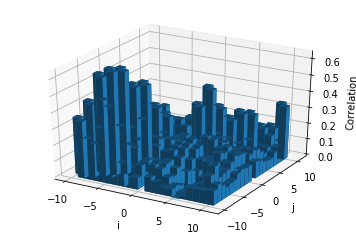

In [37]:
K=10
xs = []
ys = []
dx = 1
dy = 1
dz = []

i = 0
for k1 in range(-K,K+1):
    if k1 != 0:
        j = 0
        for k2 in range(-K,K+1):
            if k2 != 0:
                if k1 != k2:
                    xs.append(k1)
                    ys.append(k2)
                    dz.append(sigma[i][j])
                j += 1
        i += 1
        
                
zs = np.zeros(len(xs))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.bar3d(xs, ys, zs, dx, dy, dz, shade=True)
plt.xlabel("i")
plt.ylabel("j")
ax1.set_zlabel("Correlation")
plt.savefig('pos_pos_correlations')
plt.show()

In [38]:
data = {}
for k in range(-K,K+1):
    if k != 0:
        data[k] = [None for _ in range(20)]
        
pos_pos_correlations = pd.DataFrame(data, index=[k for k in range(-K,K+1) if k != 0])
i = 0
for k1 in range(-K,K+1):
    if k1 != 0:
        j = 0
        for k2 in range(-K,K+1):
            if k2 != 0:
                pos_pos_correlations[k1][k2] = round(sigma[i][j],2)
                j += 1
        i += 1
        
with pd.ExcelWriter('pos_pos_correlations.xlsx') as writer:
    pos_pos_correlations.to_excel(writer)
    
pos_pos_correlations

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1,0.35,0.25,0.23,0.2,0.16,0.13,0.15,0.06,0.07,0.09,0.07,0.05,0.05,-0,0.02,0.08,0.08,0.08,0.09
-9,0.35,1,0.45,0.31,0.23,0.17,0.12,0.14,0.11,0.14,0.15,0.14,0.1,0.05,0.01,0.02,0.06,0.09,0.16,0.11
-8,0.25,0.45,1,0.61,0.44,0.27,0.2,0.23,0.1,0.14,0.16,0.16,0.09,0.04,0.01,0.03,0.07,0.09,0.2,0.09
-7,0.23,0.31,0.61,1,0.63,0.31,0.16,0.2,0.04,0.14,0.14,0.16,0.12,0.02,0.02,-0.02,0.03,0.11,0.12,0.06
-6,0.2,0.23,0.44,0.63,1,0.63,0.3,0.23,0.04,0.13,0.2,0.21,0.17,0.1,-0,-0.01,0.04,0.11,0.12,0.07
-5,0.16,0.17,0.27,0.31,0.63,1,0.53,0.34,0.14,0.2,0.26,0.22,0.21,0.15,0.09,0.06,0.07,0.09,0.13,0.07
-4,0.13,0.12,0.2,0.16,0.3,0.53,1,0.54,0.23,0.23,0.24,0.23,0.23,0.2,0.15,0.14,0.14,0.11,0.16,0.1
-3,0.15,0.14,0.23,0.2,0.23,0.34,0.54,1,0.4,0.25,0.24,0.26,0.24,0.21,0.14,0.13,0.19,0.14,0.21,0.11
-2,0.06,0.11,0.1,0.04,0.04,0.14,0.23,0.4,1,0.34,0.22,0.21,0.17,0.14,0.13,0.14,0.18,0.12,0.18,0.11
-1,0.07,0.14,0.14,0.14,0.13,0.2,0.23,0.25,0.34,1,0.28,0.21,0.2,0.24,0.23,0.18,0.2,0.15,0.18,0.11


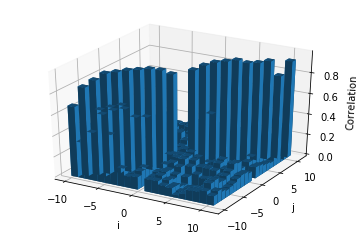

In [39]:
xs = []
ys = []
dx = 1
dy = 1
dz = []

i = 0
for k1 in range(-K,K+1):
    if k1 != 0:
        j = 20
        for k2 in range(-K,K+1):
            if k2 != 0:
                xs.append(k1)
                ys.append(k2)
                dz.append(sigma[i][j])
                j += 1
        i += 1
        
                
zs = np.zeros(len(xs))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.bar3d(xs, ys, zs, dx, dy, dz, shade=True)
plt.xlabel("i")
plt.ylabel("j")
ax1.set_zlabel("Correlation")
plt.savefig('pos_neg_correlations')
plt.show()

In [40]:
data = {}
for k in range(-K,K+1):
    if k != 0:
        data[k] = [None for _ in range(20)]
        
pos_neg_correlations = pd.DataFrame(data, index=[k for k in range(-K,K+1) if k != 0])
i = 0
for k1 in range(-K,K+1):
    if k1 != 0:
        j = 20
        for k2 in range(-K,K+1):
            if k2 != 0:
                pos_neg_correlations[k1][k2] = round(sigma[i][j],2)
                j += 1
        i += 1
        
with pd.ExcelWriter('pos_neg_correlations.xlsx') as writer:
    pos_neg_correlations.to_excel(writer)
        
pos_neg_correlations

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,0.68,0.35,0.27,0.22,0.21,0.17,0.15,0.18,0.11,0.12,0.12,0.13,0.09,0.08,0.03,0.05,0.1,0.1,0.12,0.09
-9,0.32,0.85,0.44,0.29,0.22,0.17,0.14,0.14,0.12,0.16,0.13,0.15,0.12,0.08,0.04,0.04,0.07,0.1,0.18,0.11
-8,0.23,0.47,0.91,0.6,0.42,0.25,0.18,0.19,0.09,0.17,0.15,0.17,0.11,0.05,0.01,0.04,0.07,0.1,0.18,0.08
-7,0.23,0.3,0.61,0.96,0.63,0.31,0.15,0.18,0.05,0.16,0.13,0.16,0.13,0.03,0.02,-0.02,0.03,0.12,0.13,0.07
-6,0.19,0.23,0.43,0.62,0.96,0.63,0.29,0.21,0.04,0.14,0.18,0.21,0.18,0.1,0,-0.01,0.04,0.11,0.12,0.08
-5,0.16,0.17,0.27,0.32,0.63,0.97,0.55,0.35,0.15,0.22,0.25,0.24,0.23,0.17,0.11,0.08,0.09,0.11,0.15,0.09
-4,0.14,0.14,0.2,0.16,0.29,0.53,0.97,0.54,0.24,0.24,0.23,0.24,0.24,0.21,0.16,0.16,0.15,0.12,0.17,0.11
-3,0.15,0.16,0.24,0.2,0.24,0.35,0.55,0.97,0.42,0.26,0.25,0.27,0.25,0.22,0.14,0.14,0.2,0.16,0.22,0.12
-2,0.09,0.15,0.15,0.1,0.1,0.2,0.3,0.49,0.95,0.39,0.26,0.23,0.2,0.17,0.16,0.17,0.21,0.15,0.21,0.12
-1,0.09,0.13,0.17,0.15,0.17,0.21,0.23,0.25,0.31,0.9,0.3,0.16,0.14,0.2,0.19,0.14,0.14,0.1,0.13,0.09


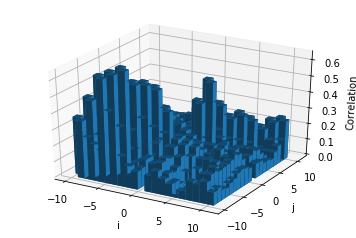

In [41]:
xs = []
ys = []
dx = 1
dy = 1
dz = []

i = 20
for k1 in range(-K,K+1):
    if k1 != 0:
        j = 20
        for k2 in range(-K,K+1):
            if k2 != 0:
                if k1 != k2:
                    xs.append(k1)
                    ys.append(k2)
                    dz.append(sigma[i][j])
                j += 1
        i += 1
                
zs = np.zeros(len(xs))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.bar3d(xs, ys, zs, dx, dy, dz, shade=True)
plt.xlabel("i")
plt.ylabel("j")
ax1.set_zlabel("Correlation")
plt.savefig('neg_neg_correlations')
plt.show()

In [42]:
data = {}
for k in range(-K,K+1):
    if k != 0:
        data[k] = [None for _ in range(20)]
        
neg_neg_correlations = pd.DataFrame(data, index=[k for k in range(-K,K+1) if k != 0])
i = 20
for k1 in range(-K,K+1):
    if k1 != 0:
        j = 20
        for k2 in range(-K,K+1):
            if k2 != 0:
                neg_neg_correlations[k1][k2] = round(sigma[i][j],2)
                j += 1
        i += 1
        
with pd.ExcelWriter('neg_neg_correlations.xlsx') as writer:
    neg_neg_correlations.to_excel(writer)        
        
neg_neg_correlations

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1,0.36,0.27,0.23,0.2,0.18,0.16,0.19,0.14,0.11,0.1,0.14,0.1,0.08,0.02,0.05,0.12,0.11,0.14,0.08
-9,0.36,1,0.48,0.28,0.22,0.18,0.16,0.15,0.14,0.12,0.16,0.18,0.12,0.08,0.03,0.04,0.09,0.09,0.17,0.09
-8,0.27,0.48,1,0.6,0.42,0.26,0.19,0.21,0.14,0.16,0.14,0.19,0.11,0.05,0.01,0.04,0.08,0.11,0.2,0.07
-7,0.23,0.28,0.6,1,0.62,0.32,0.15,0.19,0.1,0.16,0.11,0.18,0.13,0.03,0.02,-0.01,0.05,0.14,0.16,0.06
-6,0.2,0.22,0.42,0.62,1,0.64,0.29,0.22,0.08,0.15,0.14,0.23,0.18,0.1,0,-0,0.06,0.13,0.16,0.07
-5,0.18,0.18,0.26,0.32,0.64,1,0.55,0.36,0.21,0.21,0.21,0.27,0.24,0.18,0.11,0.08,0.1,0.12,0.17,0.08
-4,0.16,0.16,0.19,0.15,0.29,0.55,1,0.54,0.3,0.22,0.2,0.27,0.25,0.22,0.16,0.16,0.15,0.13,0.18,0.11
-3,0.19,0.15,0.21,0.19,0.22,0.36,0.54,1,0.51,0.25,0.19,0.29,0.27,0.23,0.14,0.15,0.21,0.18,0.23,0.11
-2,0.14,0.14,0.14,0.1,0.08,0.21,0.3,0.51,1,0.37,0.23,0.24,0.22,0.17,0.15,0.18,0.23,0.16,0.19,0.11
-1,0.11,0.12,0.16,0.16,0.15,0.21,0.22,0.25,0.37,1,0.26,0.16,0.15,0.19,0.19,0.16,0.17,0.12,0.14,0.09


# Simulation

In [4]:

    
def inverse_PDF_Poisson(average, u):
    x = 0
    p = np.exp(-average)
    s = p
    while u > s:
        x += 1
        p = p * average / x
        s = s + p
    return x  

def arrivals_during_time_period(AESs, average_rates, correlations, start_time, T):
    correlated_normals = np.random.multivariate_normal(mean=[0 for _ in AESs], cov=correlations)
    us = [norm.cdf(y) for y in correlated_normals]
    num_arrivals = [inverse_PDF_Poisson(rate*T,u) for (rate,u) in zip(average_rates,us)]
    labels = [(k,"pos") for k in range(-K,K+1) if k != 0] + [(k,"neg") for k in range(-K,K+1) if k != 0]
    events = []
    for i,n in enumerate(num_arrivals):
        position, direction = labels[i]
        for _ in range(n):
            arrival_time = start_time + np.random.uniform()*T
            arrival_size = min(np.random.exponential(AESs[i]),5000)
            if direction == "neg":
                arrival_size *= -1
            events.append((arrival_time, arrival_size, position, False))
    return events        

In [5]:
average_sizes

OrderedDict([(-10, 287.1343261066107),
             (-9, 250.14440598382774),
             (-8, 292.8595557315305),
             (-7, 609.8154879314532),
             (-6, 1338.8977034506945),
             (-5, 2578.2647828454283),
             (-4, 2735.4364300829075),
             (-3, 2328.270135971142),
             (-2, 1425.6754816026087),
             (-1, 587.9266763538596),
             (1, 495.78529919956264),
             (2, 983.2351859382003),
             (3, 1475.5901257103164),
             (4, 2170.5963486266273),
             (5, 2456.864847931035),
             (6, 1807.15589047753),
             (7, 817.156989876897),
             (8, 420.6087178769215),
             (9, 404.1115441720219),
             (10, 390.98856591945906)])

In [6]:
def simulate(starting_ref_price, starting_book, starting_time, num_intervals, T, A, market_orders, rates=None):
    ref_price = starting_ref_price
    sizes = copy.copy(starting_book)
    interval_start = starting_time
    
    # Find the market orders in each interval
    orders_in_interval = OrderedDict([(i,[]) for i in range(num_intervals)])
    i = 0
    for order in market_orders:
        if order[0] > starting_time + (i+1)*T:
            i += 1
        orders_in_interval[i].append(order)
            
    # Amount left to buy
    a = A
    
    # Prices and amounts
    filled_orders = []
    
    
    for n in range(num_intervals):       
        interval_start = n*T
        if rates == None:
            events = arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, interval_start, T)
        else:
            events = arrivals_during_time_period(AESs_vector, rates[n], sigma, interval_start, T)
        orders = [(t,-size,1,True) for (t,size) in orders_in_interval[n]]
        # Finish ordering all that is left
        if n == (num_intervals-1) and a > 0:
            orders.append(((n+1)*T,-a,1,True))
        all_events = sorted(events + orders, key=lambda x: x[0])
        
        for (t,change,k,is_order) in all_events:
            
            if False:
                print("Interval: {}".format(n + 1))
                print("Ref price: {}".format(ref_price))
                for x in sizes:
                    if abs(ref_price - x) < K:
                        print("{}: {}".format(x,sizes[x]))
                print("Event: time = {}, k = {}, change = {}, order = {}".format(t,k,change,is_order))
                print()
                print()
                
            if is_order:
                left_to_fill = min(-change,a)
                p = round(ref_price + 0.5)
                while p < 617 and sizes[p] < left_to_fill:
                    if sizes[p] > 0:
                        filled_orders.append((t,p,sizes[p]))
                    left_to_fill -= sizes[p]
                    sizes[p] = 0
                    p += 1
                if left_to_fill > 0:
                    filled_orders.append((t,p,left_to_fill))
                sizes[p] = max(0,sizes[p] - left_to_fill)
                left_to_fill = 0
                
                a = max(0, a + change)
            
            else:    
                # Negative event
                if change < 0:
                    # Check if first:
                    if k < 0:
                        price = round(ref_price + 0.5 + k)
                        is_first = True
                        for p in reversed(range(price + 1,round(ref_price + 0.5))):
                            if sizes[p] > 0:
                                is_first = False

                        # If first, go down prices
                        if is_first:
                            p = price
                            amount_left = -change
                            while i > 0 and sizes[p] < amount_left:
                                amount_left -= sizes[p]
                                sizes[p] = 0
                                p -= 1
                            sizes[p] = max(0, sizes[p] - amount_left)
                        # Otherwise, just subtract
                        else:
                            sizes[price] = max(0, sizes[price] + change) 

                    else:
                        price = round(ref_price - 0.5 + k)
                        is_first = True
                        for p in range(round(ref_price + 0.5),price):
                            if sizes[p] > 0:
                                is_first = False

                        # If first, go down prices
                        if is_first:
                            p = price
                            amount_left = -change
                            while p < 1017 and sizes[p] < amount_left:
                                amount_left -= sizes[p]
                                sizes[p] = 0
                                p += 1
                            sizes[p] = max(0, sizes[p] - amount_left)
                        else:
                            sizes[price] = max(0, sizes[price] + change)

                # Positive events
                else:
                    if k < 0:
                        price = round(ref_price + 0.5 + k)
                    else:
                        price = round(ref_price - 0.5 + k)
                    sizes[price] += change
                
            # Update ref price
            for p in range(round(ref_price + 0.5),1017):
                if sizes[p] != 0:
                    first_ask_price = p
                    break
            for p in reversed(range(0,round(ref_price + 0.5))):
                if sizes[p] != 0:
                    first_bid_price = p
                    break
        
            if (first_ask_price - first_bid_price) % 2 != 0:
                ref_price = round(float(first_ask_price + first_bid_price) / 2,1)
            else:
                middle_price = round((first_ask_price + first_bid_price)/2)
                if middle_price < ref_price:
                    ref_price = round(middle_price + 0.5, 1)
                else:
                    ref_price = round(middle_price - 0.5, 1)
                    
    return filled_orders

In [7]:
K=10
starting_sizes = copy.deepcopy(average_sizes)

average_price = 516.5

starting_book = OrderedDict()
for i in range(0,round(average_price + 0.5 - K)):
    starting_book[i] = 100
for k in range(-K,0):
    starting_book[round(average_price+0.5+k)] = starting_sizes[k]
for k in range(1,K+1):
    starting_book[round(average_price-0.5+k)] = starting_sizes[k]
for i in range(round(average_price + 0.5 + K), round(average_price + 0.5 + 500)):
    starting_book[i] = 100

In [8]:
def vwap(filled_orders):
    weighted_sum = 0
    total_amount = 0
    for order in filled_orders:
        weighted_sum += order[1]*order[2]
        total_amount += order[2]
    return weighted_sum / total_amount

In [6]:
orders = simulate(average_price, starting_book, 0, 5, 60, 8000, [(1,2000),(61,2000),(121,2000),(181,1000)])
print("VWAP: {}".format(vwap(orders)))
orders

VWAP: 518.8170502220277


[(1, 517, 462.18989947906636),
 (1, 518, 983.2351859382003),
 (1, 519, 554.5749145827334),
 (61, 517, 1078.7557966565628),
 (61, 518, 921.2442033434372),
 (121, 519, 137.04941812104894),
 (121, 520, 1862.950581878951),
 (181, 519, 273.08958631539514),
 (181, 520, 726.9104136846049),
 (300, 519, 67.08843778905616),
 (300, 520, 932.9115622109439)]

In [7]:
orders = simulate(516.5, starting_book, 0, 10, 60, 40000, [(150,1000)])
print("VWAP: {}".format(vwap(orders)))
orders

VWAP: 519.4628195760913


[(150, 517, 1000),
 (300, 518, 546.2898482704597),
 (300, 519, 2017.0698680767985),
 (300, 520, 2624.434110304246),
 (300, 521, 1812.2061733484961)]

In [8]:
def simulate_split(num_minutes, A, num_trades):
    order_size = A / num_trades
    market_orders = []
    for i in range(1,num_trades+1):
        market_orders.append(((num_minutes*60)*i/(num_trades+1),order_size))
    orders = simulate(average_price, starting_book, 0, num_minutes, 60, A, market_orders)
    return vwap(orders)

In [23]:
def simulate_split_orders(num_minutes, A, num_trades):
    order_size = A / num_trades
    market_orders = []
    for i in range(1,num_trades+1):
        market_orders.append(((num_minutes*60)*i/(num_trades+1),order_size))
    orders = simulate(average_price, starting_book, 0, num_minutes, 60, A, market_orders)
    return orders

orders = simulate_split_orders(10, 40000, 8)
print("VWAP: {}".format(vwap(orders)))
for t,price,volume in orders:
    print("{} {} {}".format(t,price,volume))

VWAP: 524.8200986363015
66.66666666666667 517 682.6956580935788
66.66666666666667 518 428.5940594470293
66.66666666666667 519 2566.0223840149183
66.66666666666667 520 1301.6438398411715
66.66666666666667 521 21.044058603302346
133.33333333333334 520 260.56521055870604
133.33333333333334 521 1454.8264479131435
133.33333333333334 522 2239.505991219662
133.33333333333334 523 490.2009793890609
133.33333333333334 524 554.9013709194276
200.0 522 62.54971416494775
200.0 523 133.96560194041646
200.0 524 3165.501462612425
200.0 525 1637.9832212822112
266.6666666666667 521 302.56262063564924
266.6666666666667 522 411.77749162473924
266.6666666666667 523 584.959715289532
266.6666666666667 524 3541.5948691209605
266.6666666666667 525 159.10530332911912
333.3333333333333 524 684.0537231267291
333.3333333333333 525 981.6167356150888
333.3333333333333 526 3334.329541258182
400.0 525 891.3523918225865
400.0 526 1403.4009582530912
400.0 527 1557.5074321182065
400.0 528 1147.739217806116
466.66666666666

In [9]:
n = 10000
A = 40000
minutes = 10

In [13]:
vwaps = []

In [18]:
vwaps_1 = []
for i in range(n):
    vwaps_1.append(simulate_split(minutes,A,1))
    if (i+1) % 1000 == 0:
        print(i+1)
vwaps.append(vwaps_1)

In [17]:
print("Split at {}".format(1))
print("Mean = {}, Std = {}".format(np.mean(vwaps[0]),np.std(vwaps[0])))

Split at 1
Mean = 573.4806214150248, Std = 8.379568574705873


In [16]:
vwaps_2 = []
for i in range(n):
    vwaps_2.append(simulate_split(minutes,A,2))
    if (i+1) % 1000 == 0:
        print(i+1)
vwaps.append(vwaps_2)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [18]:
print("Split at {}".format(2))
print("Mean = {}, Std = {}".format(np.mean(vwaps[1]),np.std(vwaps[1])))

Split at 2
Mean = 566.0529381540007, Std = 11.569014312217716


In [19]:
vwaps_3 = []
for i in range(n):
    vwaps_3.append(simulate_split(minutes,A,3))
    if (i+1) % 1000 == 0:
        print(i+1)
vwaps.append(vwaps_3)
print("Split at {}".format(3))
print("Mean = {}, Std = {}".format(np.mean(vwaps[2]),np.std(vwaps[2])))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Split at 3
Mean = 558.1117733740688, Std = 12.958475108604462


In [20]:
vwaps_4 = []
for i in range(n):
    vwaps_4.append(simulate_split(minutes,A,4))
    if (i+1) % 1000 == 0:
        print(i+1)
vwaps.append(vwaps_4)
print("Split at {}".format(4))
print("Mean = {}, Std = {}".format(np.mean(vwaps[3]),np.std(vwaps[3])))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Split at 4
Mean = 551.2220025822061, Std = 13.93711622321697


In [21]:
vwaps_5 = []
for i in range(n):
    vwaps_5.append(simulate_split(minutes,A,5))
    if (i+1) % 1000 == 0:
        print(i+1)
vwaps.append(vwaps_5)
print("Split at {}".format(5))
print("Mean = {}, Std = {}".format(np.mean(vwaps[4]),np.std(vwaps[4])))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Split at 5
Mean = 542.8954381118217, Std = 13.612077012250229


In [22]:
vwaps_6 = []
for i in range(n):
    vwaps_6.append(simulate_split(minutes,A,6))
    if (i+1) % 1000 == 0:
        print(i+1)
vwaps.append(vwaps_6)
print("Split at {}".format(6))
print("Mean = {}, Std = {}".format(np.mean(vwaps[5]),np.std(vwaps[5])))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Split at 6
Mean = 536.1912080539198, Std = 12.039010769133538


In [23]:
vwaps_7 = []
for i in range(n):
    vwaps_7.append(simulate_split(minutes,A,7))
    if (i+1) % 1000 == 0:
        print(i+1)
vwaps.append(vwaps_7)
print("Split at {}".format(7))
print("Mean = {}, Std = {}".format(np.mean(vwaps[6]),np.std(vwaps[6])))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Split at 7
Mean = 531.5256225681586, Std = 9.60091157312534


In [24]:
vwaps_8 = []
for i in range(n):
    vwaps_8.append(simulate_split(minutes,A,8))
    if (i+1) % 1000 == 0:
        print(i+1)
vwaps.append(vwaps_8)
print("Split at {}".format(8))
print("Mean = {}, Std = {}".format(np.mean(vwaps[7]),np.std(vwaps[7])))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Split at 8
Mean = 529.2860569065448, Std = 8.064859944031724


In [25]:
vwaps_9 = []
for i in range(n):
    vwaps_9.append(simulate_split(minutes,A,9))
    if (i+1) % 1000 == 0:
        print(i+1)
vwaps.append(vwaps_9)
print("Split at {}".format(9))
print("Mean = {}, Std = {}".format(np.mean(vwaps[8]),np.std(vwaps[8])))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Split at 9
Mean = 529.4820879583963, Std = 8.17386036719033


In [26]:
vwaps_10 = []
for i in range(n):
    vwaps_10.append(simulate_split(minutes,A,10))
    if (i+1) % 1000 == 0:
        print(i+1)
vwaps.append(vwaps_10)
print("Split at {}".format(10))
print("Mean = {}, Std = {}".format(np.mean(vwaps[9]),np.std(vwaps[9])))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Split at 10
Mean = 528.4896067140463, Std = 7.012137622184474


In [27]:
vwaps_100 = []
for i in range(n):
    vwaps_100.append(simulate_split(minutes,A,100))
    if (i+1) % 1000 == 0:
        print(i+1)
        
print("Split at {}".format(100))
print("Mean = {}, Std = {}".format(np.mean(vwaps_100),np.std(vwaps_100)))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Split at 100
Mean = 529.3184577859065, Std = 6.092547775723834


In [56]:
for i in range(1,11):
    print("Split at {}".format(i))
    print("Mean = {}, Std = {}, SEM = {}".format(np.mean(vwaps[i-1]),ss.tstd(vwaps[i-1]), ss.sem(vwaps[i-1])))
    
print("Split at 100")
print("Mean = {}, Std = {}, SEM = {}".format(np.mean(vwaps_100),ss.tstd(vwaps_100), ss.sem(vwaps_100)))

Split at 1
Mean = 573.4806214150248, Std = 8.37998758456061, SEM = 0.0837998758456061
Split at 2
Mean = 566.0529381540007, Std = 11.569592806320747, SEM = 0.11569592806320747
Split at 3
Mean = 558.1117733740688, Std = 12.959123080958225, SEM = 0.12959123080958224
Split at 4
Mean = 551.2220025822061, Std = 13.937813131296673, SEM = 0.13937813131296672
Split at 5
Mean = 542.8954381118217, Std = 13.612757667150383, SEM = 0.13612757667150382
Split at 6
Mean = 536.1912080539198, Std = 12.039612764822047, SEM = 0.12039612764822047
Split at 7
Mean = 531.5256225681586, Std = 9.601391654710415, SEM = 0.09601391654710416
Split at 8
Mean = 529.2860569065448, Std = 8.065263217274671, SEM = 0.08065263217274671
Split at 9
Mean = 529.4820879583963, Std = 8.17426909086322, SEM = 0.0817426909086322
Split at 10
Mean = 528.4896067140463, Std = 7.012488255363291, SEM = 0.0701248825536329
Split at 100
Mean = 529.3184577859065, Std = 6.092852425961578, SEM = 0.06092852425961578


In [10]:
def simulate_split_2rates(num_minutes, A, num_trades, first_half_market_activity, first_half_trade_activity):
    order_size_average = A / num_trades
    order_size_first_half = order_size_average * first_half_trade_activity / 0.5
    order_size_second_half = order_size_average * (1 - first_half_trade_activity) / 0.5
    
    market_orders = []
    for i in range(1,num_trades+1):
        if i <= num_trades / 2:
            market_orders.append(((num_minutes*60)*i/(num_trades+1),order_size_first_half))
        else:
            market_orders.append(((num_minutes*60)*i/(num_trades+1),order_size_second_half))
            
    first_half_rates = [r*first_half_market_activity/0.5 for r in average_rates_vector]
    second_half_rates = [r*(1-first_half_market_activity)/0.5 for r in average_rates_vector]

    rates = OrderedDict([(n,None) for n in range(num_minutes)])
    for n in range(num_minutes):
        if n < num_minutes / 2:
            rates[n] = first_half_rates
        else:
            rates[n] = second_half_rates
            
    orders = simulate(average_price, starting_book, 0, num_minutes, 60, A, market_orders,rates=rates)
    return vwap(orders)

In [11]:
simulate_split_2rates(10,A,20,0.75,.75)

522.8539758381401

In [15]:
def simulate_split_2rates_orders(num_minutes, A, num_trades, first_half_market_activity, first_half_trade_activity):
    order_size_average = A / num_trades
    order_size_first_half = order_size_average * first_half_trade_activity / 0.5
    order_size_second_half = order_size_average * (1 - first_half_trade_activity) / 0.5
    
    market_orders = []
    for i in range(1,num_trades+1):
        if i <= num_trades / 2:
            market_orders.append(((num_minutes*60)*i/(num_trades+1),order_size_first_half))
        else:
            market_orders.append(((num_minutes*60)*i/(num_trades+1),order_size_second_half))
            
    first_half_rates = [r*first_half_market_activity/0.5 for r in average_rates_vector]
    second_half_rates = [r*(1-first_half_market_activity)/0.5 for r in average_rates_vector]

    rates = OrderedDict([(n,None) for n in range(num_minutes)])
    for n in range(num_minutes):
        if n < num_minutes / 2:
            rates[n] = first_half_rates
        else:
            rates[n] = second_half_rates
            
    orders = simulate(average_price, starting_book, 0, num_minutes, 60, A, market_orders,rates=rates)
    return orders

orders = simulate_split_2rates_orders(10, 40000, 8, 0.75, 0.75)
print("VWAP: {}".format(vwap(orders)))
for t,price,volume in orders:
    print("{} {} {}".format(t,price,volume))

VWAP: 522.506865555793
66.66666666666667 517 1071.6099305589048
66.66666666666667 519 1907.3205623405615
66.66666666666667 520 4116.338950706983
66.66666666666667 521 404.7305563935506
133.33333333333334 518 2145.428089028127
133.33333333333334 521 4555.105691680634
133.33333333333334 522 799.4662192912392
200.0 518 207.0433723720572
200.0 519 856.1499171146145
200.0 520 1513.2019844571353
200.0 521 835.5557932096888
200.0 522 1043.6994667651788
200.0 523 3044.3494660813258
266.6666666666667 521 507.42433844117176
266.6666666666667 522 2825.698893361444
266.6666666666667 523 1860.74608015928
266.6666666666667 524 1134.1895554274106
266.6666666666667 525 1171.9411326106938
333.3333333333333 524 516.3002300503455
333.3333333333333 525 1676.603251495263
333.3333333333333 526 307.09651845439157
400.0 525 968.9084720810508
400.0 527 759.6570534179809
400.0 528 771.4344745009682
466.6666666666667 525 357.557859888222
466.6666666666667 526 71.18785870497871
466.6666666666667 527 807.991736884

#### Rate = 0.6

In [12]:
trials_with_vwap = {}
trials_without_vwap = {}

In [13]:
trials_with_vwap[(0.6,4)] = [simulate_split_2rates(10,A,4,0.6,0.6) for _ in range(n)]
trials_without_vwap[(0.6,4)] = [simulate_split_2rates(10,A,4,0.6,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.6,4)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.6,4)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.6,4)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.6,4)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.6,4)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.6,4)])))

Mean with VWAP: 547.8693080340488
Std with VWAP: 15.56359543004263
SEM with VWAP: 0.15563595430042632
Mean without VWAP: 545.6422386491283
Std without VWAP: 14.419665889712153
SEM without VWAP: 0.14419665889712152


In [14]:
trials_with_vwap[(0.6,8)] = [simulate_split_2rates(10,A,8,0.6,0.6) for _ in range(n)]
trials_without_vwap[(0.6,8)] = [simulate_split_2rates(10,A,8,0.6,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.6,8)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.6,8)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.6,8)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.6,8)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.6,8)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.6,8)])))

Mean with VWAP: 529.3396813738419
Std with VWAP: 8.481962397665304
SEM with VWAP: 0.08481962397665305
Mean without VWAP: 528.208125422883
Std without VWAP: 7.076305996186799
SEM without VWAP: 0.07076305996186799


In [15]:
trials_with_vwap[(0.6,12)] = [simulate_split_2rates(10,A,12,0.6,0.6) for _ in range(n)]
trials_without_vwap[(0.6,12)] = [simulate_split_2rates(10,A,12,0.6,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.6,12)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.6,12)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.6,12)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.6,12)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.6,12)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.6,12)])))

Mean with VWAP: 528.0647114818491
Std with VWAP: 6.805710901754939
SEM with VWAP: 0.06805710901754938
Mean without VWAP: 527.5137421331217
Std without VWAP: 5.850697332995101
SEM without VWAP: 0.05850697332995101


In [16]:
trials_with_vwap[(0.6,16)] = [simulate_split_2rates(10,A,16,0.6,0.6) for _ in range(n)]
trials_without_vwap[(0.6,16)] = [simulate_split_2rates(10,A,16,0.6,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.6,16)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.6,16)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.6,16)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.6,16)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.6,16)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.6,16)])))

Mean with VWAP: 527.6739475166617
Std with VWAP: 5.881280200345291
SEM with VWAP: 0.05881280200345291
Mean without VWAP: 527.3832544933574
Std without VWAP: 5.1963048229189095
SEM without VWAP: 0.051963048229189096


In [17]:
trials_with_vwap[(0.6,20)] = [simulate_split_2rates(10,A,20,0.6,0.6) for _ in range(n)]
trials_without_vwap[(0.6,20)] = [simulate_split_2rates(10,A,20,0.6,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.6,20)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.6,20)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.6,20)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.6,20)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.6,20)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.6,20)])))

Mean with VWAP: 527.8402618664969
Std with VWAP: 5.688362419281093
SEM with VWAP: 0.05688362419281093
Mean without VWAP: 527.3662837356056
Std without VWAP: 4.958546819671193
SEM without VWAP: 0.04958546819671193


#### Rate = 0.7

In [18]:
trials_with_vwap[(0.7,4)] = [simulate_split_2rates(10,A,4,0.7,0.7) for _ in range(n)]
trials_without_vwap[(0.7,4)] = [simulate_split_2rates(10,A,4,0.7,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.7,4)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.7,4)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.7,4)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.7,4)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.7,4)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.7,4)])))

Mean with VWAP: 547.4370614780246
Std with VWAP: 15.82974914256302
SEM with VWAP: 0.1582974914256302
Mean without VWAP: 541.3493868304043
Std without VWAP: 14.208706416803473
SEM without VWAP: 0.14208706416803474


In [19]:
trials_with_vwap[(0.7,8)] = [simulate_split_2rates(10,A,8,0.7,0.7) for _ in range(n)]
trials_without_vwap[(0.7,8)] = [simulate_split_2rates(10,A,8,0.7,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.7,8)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.7,8)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.7,8)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.7,8)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.7,8)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.7,8)])))

Mean with VWAP: 529.7884160283018
Std with VWAP: 9.29520107445115
SEM with VWAP: 0.0929520107445115
Mean without VWAP: 528.2572070162522
Std without VWAP: 6.713426092056221
SEM without VWAP: 0.06713426092056221


In [20]:
trials_with_vwap[(0.7,12)] = [simulate_split_2rates(10,A,12,0.7,0.7) for _ in range(n)]
trials_without_vwap[(0.7,12)] = [simulate_split_2rates(10,A,12,0.7,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.7,12)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.7,12)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.7,12)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.7,12)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.7,12)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.7,12)])))

Mean with VWAP: 528.086269561243
Std with VWAP: 7.156338348984002
SEM with VWAP: 0.07156338348984001
Mean without VWAP: 527.5755537450594
Std without VWAP: 5.860238519225673
SEM without VWAP: 0.05860238519225673


In [21]:
trials_with_vwap[(0.7,16)] = [simulate_split_2rates(10,A,16,0.7,0.7) for _ in range(n)]
trials_without_vwap[(0.7,16)] = [simulate_split_2rates(10,A,16,0.7,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.7,16)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.7,16)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.7,16)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.7,16)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.7,16)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.7,16)])))

Mean with VWAP: 527.6915249927173
Std with VWAP: 6.278834839345656
SEM with VWAP: 0.06278834839345655
Mean without VWAP: 527.4916810318064
Std without VWAP: 5.494669577722503
SEM without VWAP: 0.054946695777225024


In [22]:
trials_with_vwap[(0.7,20)] = [simulate_split_2rates(10,A,20,0.7,0.7) for _ in range(n)]
trials_without_vwap[(0.7,20)] = [simulate_split_2rates(10,A,20,0.7,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.7,20)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.7,20)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.7,20)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.7,20)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.7,20)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.7,20)])))

Mean with VWAP: 527.5003700683035
Std with VWAP: 5.660017644275724
SEM with VWAP: 0.05660017644275724
Mean without VWAP: 527.5125517829122
Std without VWAP: 5.218217366739023
SEM without VWAP: 0.05218217366739023


#### Rate = 0.8

In [23]:
trials_with_vwap[(0.8,4)] = [simulate_split_2rates(10,A,4,0.8,0.8) for _ in range(n)]
trials_without_vwap[(0.8,4)] = [simulate_split_2rates(10,A,4,0.8,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.8,4)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.8,4)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.8,4)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.8,4)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.8,4)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.8,4)])))

Mean with VWAP: 548.4953992869924
Std with VWAP: 15.205898994266793
SEM with VWAP: 0.15205898994266792
Mean without VWAP: 537.1365363368672
Std without VWAP: 13.271550927077444
SEM without VWAP: 0.13271550927077444


In [24]:
trials_with_vwap[(0.8,8)] = [simulate_split_2rates(10,A,8,0.8,0.8) for _ in range(n)]
trials_without_vwap[(0.8,8)] = [simulate_split_2rates(10,A,8,0.8,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.8,8)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.8,8)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.8,8)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.8,8)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.8,8)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.8,8)])))

Mean with VWAP: 530.9429451835631
Std with VWAP: 10.457314842522628
SEM with VWAP: 0.10457314842522628
Mean without VWAP: 529.0140662910588
Std without VWAP: 7.155884298016713
SEM without VWAP: 0.07155884298016713


In [25]:
trials_with_vwap[(0.8,12)] = [simulate_split_2rates(10,A,12,0.8,0.8) for _ in range(n)]
trials_without_vwap[(0.8,12)] = [simulate_split_2rates(10,A,12,0.8,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.8,12)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.8,12)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.8,12)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.8,12)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.8,12)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.8,12)])))

Mean with VWAP: 528.4232834213615
Std with VWAP: 7.628031058431051
SEM with VWAP: 0.0762803105843105
Mean without VWAP: 528.485276521279
Std without VWAP: 6.346498679463423
SEM without VWAP: 0.06346498679463423


In [26]:
trials_with_vwap[(0.8,16)] = [simulate_split_2rates(10,A,16,0.8,0.8) for _ in range(n)]
trials_without_vwap[(0.8,16)] = [simulate_split_2rates(10,A,16,0.8,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.8,16)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.8,16)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.8,16)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.8,16)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.8,16)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.8,16)])))

Mean with VWAP: 527.7070749213383
Std with VWAP: 6.556725807765084
SEM with VWAP: 0.06556725807765085
Mean without VWAP: 528.4629863421347
Std without VWAP: 6.394165073239522
SEM without VWAP: 0.06394165073239522


In [27]:
trials_with_vwap[(0.8,20)] = [simulate_split_2rates(10,A,20,0.8,0.8) for _ in range(n)]
trials_without_vwap[(0.8,20)] = [simulate_split_2rates(10,A,20,0.8,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.8,20)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.8,20)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.8,20)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.8,20)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.8,20)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.8,20)])))

Mean with VWAP: 527.5018024454387
Std with VWAP: 5.865575547305686
SEM with VWAP: 0.05865575547305686
Mean without VWAP: 528.6918836115041
Std without VWAP: 6.32971052794472
SEM without VWAP: 0.06329710527944721


#### Rate = 0.9

In [28]:
trials_with_vwap[(0.9,4)] = [simulate_split_2rates(10,A,4,0.9,0.9) for _ in range(n)]
trials_without_vwap[(0.9,4)] = [simulate_split_2rates(10,A,4,0.9,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.9,4)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.9,4)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.9,4)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.9,4)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.9,4)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.9,4)])))

Mean with VWAP: 550.0129699523474
Std with VWAP: 14.803703030309599
SEM with VWAP: 0.14803703030309598
Mean without VWAP: 534.1701140258281
Std without VWAP: 12.353592779180836
SEM without VWAP: 0.12353592779180839


In [29]:
trials_with_vwap[(0.9,8)] = [simulate_split_2rates(10,A,8,0.9,0.9) for _ in range(n)]
trials_without_vwap[(0.9,8)] = [simulate_split_2rates(10,A,8,0.9,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.9,8)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.9,8)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.9,8)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.9,8)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.9,8)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.9,8)])))

Mean with VWAP: 531.7757390140936
Std with VWAP: 11.012878605325568
SEM with VWAP: 0.11012878605325568
Mean without VWAP: 530.6287547345678
Std without VWAP: 7.678730791838849
SEM without VWAP: 0.07678730791838849


In [30]:
trials_with_vwap[(0.9,12)] = [simulate_split_2rates(10,A,12,0.9,0.9) for _ in range(n)]
trials_without_vwap[(0.9,12)] = [simulate_split_2rates(10,A,12,0.9,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.9,12)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.9,12)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.9,12)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.9,12)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.9,12)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.9,12)])))

Mean with VWAP: 528.5737058858911
Std with VWAP: 7.959730630710406
SEM with VWAP: 0.07959730630710406
Mean without VWAP: 530.4839976614142
Std without VWAP: 7.570965817115799
SEM without VWAP: 0.07570965817115799


In [31]:
trials_with_vwap[(0.9,16)] = [simulate_split_2rates(10,A,16,0.9,0.9) for _ in range(n)]
trials_without_vwap[(0.9,16)] = [simulate_split_2rates(10,A,16,0.9,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.9,16)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.9,16)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.9,16)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.9,16)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.9,16)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.9,16)])))

Mean with VWAP: 527.673771680136
Std with VWAP: 6.640281970185534
SEM with VWAP: 0.06640281970185534
Mean without VWAP: 530.6414353204234
Std without VWAP: 7.515655896338435
SEM without VWAP: 0.07515655896338436


In [32]:
trials_with_vwap[(0.9,20)] = [simulate_split_2rates(10,A,20,0.9,0.9) for _ in range(n)]
trials_without_vwap[(0.9,20)] = [simulate_split_2rates(10,A,20,0.9,0.5) for _ in range(n)]
print("Mean with VWAP: {}".format(np.mean(trials_with_vwap[(0.9,20)])))
print("Std with VWAP: {}".format(ss.tstd(trials_with_vwap[(0.9,20)])))
print("SEM with VWAP: {}".format(ss.sem(trials_with_vwap[(0.9,20)])))
print("Mean without VWAP: {}".format(np.mean(trials_without_vwap[(0.9,20)])))
print("Std without VWAP: {}".format(ss.tstd(trials_without_vwap[(0.9,20)])))
print("SEM without VWAP: {}".format(ss.sem(trials_without_vwap[(0.9,20)])))

Mean with VWAP: 527.3732522705492
Std with VWAP: 6.03723727303637
SEM with VWAP: 0.060372372730363694
Mean without VWAP: 530.8163245249134
Std without VWAP: 7.593818775260268
SEM without VWAP: 0.07593818775260268


In [33]:
with open('vwaps_variable.pkl', 'wb') as f:
    pickle.dump([trials_with_vwap, trials_without_vwap], f)